In [1]:
import pygeostat as gs
from sdcalc import *
from scipy.interpolate import RBFInterpolator
from scipy.interpolate import LinearNDInterpolator
from scipy.interpolate import griddata
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

In [2]:
data = gs.DataFile('data/walker.dat', x='Xlocation in meter', y='Ylocation in meter')

In [3]:
sdcalc(data, 'Xlocation in meter', 'Ylocation in meter', None, 'T variable, indicator variable')

calculating signed distances for rock type 1
calculating signed distances for rock type 2


In [4]:
data.head()

,Identification Number,Xlocation in meter,Ylocation in meter,"V variable, concentration in ppm","U variable, concentration in ppm","T variable, indicator variable",signed_distances_rt_1,signed_distances_rt_2
0,1.0,11.0,8.0,0.0,NaN,2.0,168.433963,-168.433963
1,2.0,8.0,30.0,0.0,NaN,2.0,161.743624,-161.743624
2,3.0,9.0,48.0,224.4,NaN,2.0,145.890370,-145.890370
3,4.0,8.0,69.0,434.4,NaN,2.0,129.468143,-129.468143
4,5.0,9.0,90.0,412.1,NaN,2.0,113.137085,-113.137085


findfont: Font family ['Calibri'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Calibri'] not found. Falling back to DejaVu Sans.


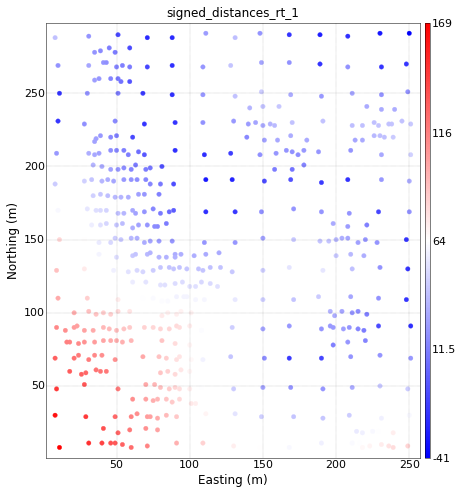

In [5]:
_ = gs.location_plot(data, var='signed_distances_rt_1', cmap='bwr', grid=True)

In [6]:
grid = data.infergriddef(blksize=((3,3,0)))

In [7]:
grid

Pygeostat GridDef:
85 4.5 3.0 
98 4.5 3.0 
1 0.5 1.0

In [8]:
grid_coords = grid.get_coordinates()
data_coords = (data[data.x].values, data[data.y].values, np.ones(len(data))*0.5)

In [9]:
def dist(p1, p2):
    x1, y1, z1 = p1[0], p1[1], p1[2]
    x2, y2, z2 = p2[0], p2[1], p2[2]
    return ((x1 - x2)**2 + (y1 - y2)**2 + (z1 - z2)**2)**0.5

In [361]:
class RBF_PoU:
    def __init__(self, data_coords, grid_coords, D, nmax):
        self.D = D
        self.nmax = nmax
        self.data_coords = data_coords
        self.xp, self.yp, self.zp = self.data_coords[0], self.data_coords[1], self.data_coords[2]
        self.grid_coords = grid_coords
        self.xg, self.yg, self.zg = self.grid_coords[0], self.grid_coords[1], self.grid_coords[2]

        self.used = []
        self.pts_idx_list = []
        self.grid_idx_list = []
        self.centers = []
        self.lower = []
        self.upper = []
        self.ul_partitions = [np.arange(len(self.xp))]

        self.weights = []
        self.acc_weights = np.zeros(len(self.xg))
        self.norm_weights = []

    def split(self, pidxs):

        xp, yp, zp = self.xp[pidxs], self.yp[pidxs], self.zp[pidxs]
        
        n = len(xp)
        print('Number of samples in Pc: {}'.format(n))
        if n > self.nmax:
            self.used.append(False)
            nn = int(np.ceil(n/2*(1+self.D)))
            print('Number of samples in Pl and Pu: {}'.format(nn))

            del self.ul_partitions[0]
        
            deltax, deltay, deltaz = np.max(xp)-np.min(xp), np.max(yp)-np.min(yp), np.max(zp)-np.min(zp)
            longaxis = np.argmax([deltax, deltay, deltaz])
            sortedindices = np.argsort([xp, yp, zp][longaxis])

            pidx1, pidx2 = sortedindices[:nn], sortedindices[n-nn:]
            self.pts_idx_list.append(pidx1)
            self.pts_idx_list.append(pidx2)
            
            self.ul_partitions.append(pidx1)
            self.ul_partitions.append(pidx2)
            
            minx1, maxx1 = np.min(xp[pidx1]), np.max(xp[pidx1])
            minx2, maxx2 = np.min(xp[pidx2]), np.max(xp[pidx2])

            miny1, maxy1 = np.min(yp[pidx1]), np.max(yp[pidx1])
            miny2, maxy2 = np.min(yp[pidx2]), np.max(yp[pidx2])

            minz1, maxz1 = np.min(zp[pidx1]), np.max(zp[pidx1])
            minz2, maxz2 = np.min(zp[pidx2]), np.max(zp[pidx2])

            cx1, cy1, cz1 = (minx1-maxx1)/2, (miny1-maxy1)/2, (minz1-maxz1)/2
            cx2, cy2, cz2 = (minx2-maxx2)/2, (miny2-maxy2)/2, (minz2-maxz2)/2
            self.centers.append([cx1, cy1, cz1])
            self.centers.append([cx2, cy2, cz2])
            self.lower.append([minx1, miny1, minz1])
            self.upper.append([maxx1, maxy1, maxz1])
            self.lower.append([minx2, miny2, minz2])
            self.upper.append([maxx2, maxy2, maxz2])

            fx1 = np.logical_and(self.xg >= minx1, self.xg <= maxx1)
            fy1 = np.logical_and(self.yg >= miny1, self.yg <= maxy1)
            fz1 = np.logical_and(self.zg >= minz1, self.zg <= maxz1)
            f1g = np.logical_and.reduce([fx1, fy1, fz1])
            self.grid_idx_list.append(f1g)

            fx2 = np.logical_and(self.xg >= minx2, self.xg <= maxx2)
            fy2 = np.logical_and(self.yg >= miny2, self.yg <= maxy2)
            fz2 = np.logical_and(self.zg >= minz2, self.zg <= maxz2)
            f2g = np.logical_and.reduce([fx2, fy2, fz2])
            self.grid_idx_list.append(f2g)

        else:
            self.used.append(True)
            del self.ul_partitions[0]
            print('Number of samples less than the treshold')

    def partition(self):
        while len(self.ul_partitions) > 0:
            self.split(self.ul_partitions[0])
        self.used = self.used[1:]

    def calculate_weights(self):
        used_idxs = self.used
        grids_idxs = np.array(self.grid_idx_list)[used_idxs]
        centers = np.array(self.centers)[used_idxs]
        lows = np.array(self.lower)[used_idxs]
        ups = np.array(self.upper)[used_idxs]

        for i, idxs in enumerate(grids_idxs):
            coords = np.array(self.grid_coords).T[idxs]
            wlist = []
            ux, uy, uz = ups[i][0], ups[i][1], ups[i][2]
            lx, ly, lz = lows[i][0], lows[i][1], lows[i][2]
            for c in coords:
                xc, yc, zc = c[0], c[1], c[2]
                #dis = 1 - ((4 * (xc-lx) * (ux-xc)) / ((ux-lx)**2) * (4 * (yc-ly) * (uy-yc)) / ((uy-ly)**2) * (4 * (zc-lz) * (uz-zc)) / ((uz-lz)**2))
                dis = 1 - ((4 * (xc-lx) * (ux-xc)) / ((ux-lx)**2) * (4 * (yc-ly) * (uy-yc)) / ((uy-ly)**2))
                wlist.append(dis)
            
            dfunc = np.array(wlist)
            wfunc = 1 - dfunc

            self.weights.append(wfunc)
            self.acc_weights[idxs] =+ wfunc

    def normalize_weights(self):
        used_idxs = self.used
        grids_idxs = np.array(self.grid_idx_list)[used_idxs]

        for i, idx in enumerate(grids_idxs):
            nw = self.weights[i]/self.acc_weights[idx]
            self.norm_weights.append(nw)

In [362]:
ptest = RBF_PoU(data_coords=data_coords, grid_coords=grid_coords, D=0.0, nmax=150)

In [363]:
ptest.partition()

Number of samples in Pc: 470
Number of samples in Pl and Pu: 235
Number of samples in Pc: 235
Number of samples in Pl and Pu: 118
Number of samples in Pc: 235
Number of samples in Pl and Pu: 118
Number of samples in Pc: 118
Number of samples less than the treshold
Number of samples in Pc: 118
Number of samples less than the treshold
Number of samples in Pc: 118
Number of samples less than the treshold
Number of samples in Pc: 118
Number of samples less than the treshold


In [364]:
ptest.calculate_weights()

In [365]:
ptest.normalize_weights()

In [366]:
print(len(ptest.used))
print(len(ptest.pts_idx_list))
print(len(ptest.grid_idx_list))
print(len(ptest.centers))
print(len(ptest.lower))
print(len(ptest.upper))
print(len(ptest.ul_partitions))

6
6
6
6
6
6
0


In [367]:
used_idxs = ptest.used

In [368]:
np.sum(used_idxs)

4

In [369]:
ups = np.array(ptest.upper)[used_idxs]
lows = np.array(ptest.lower)[used_idxs]
allups = np.array(ptest.upper)
alllows = np.array(ptest.lower)

In [370]:
len(ups)

4

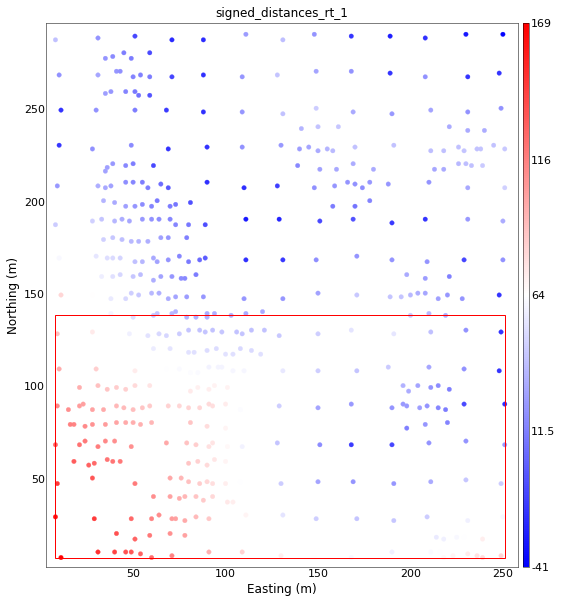

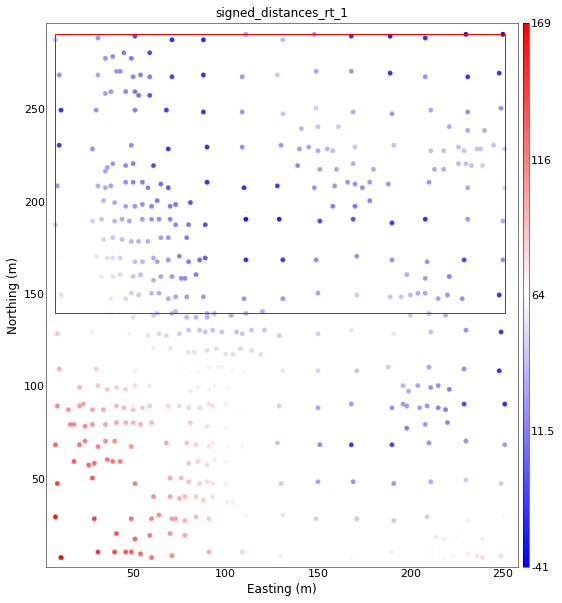

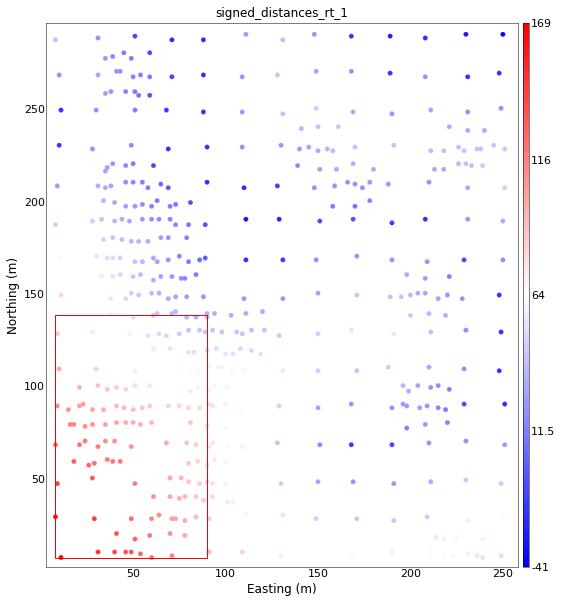

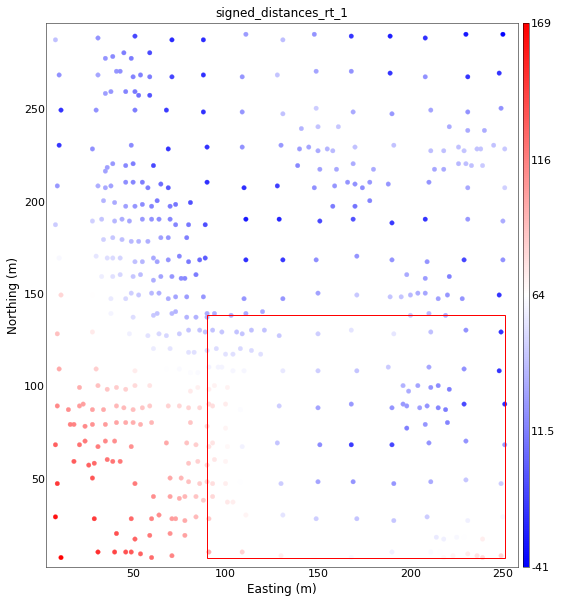

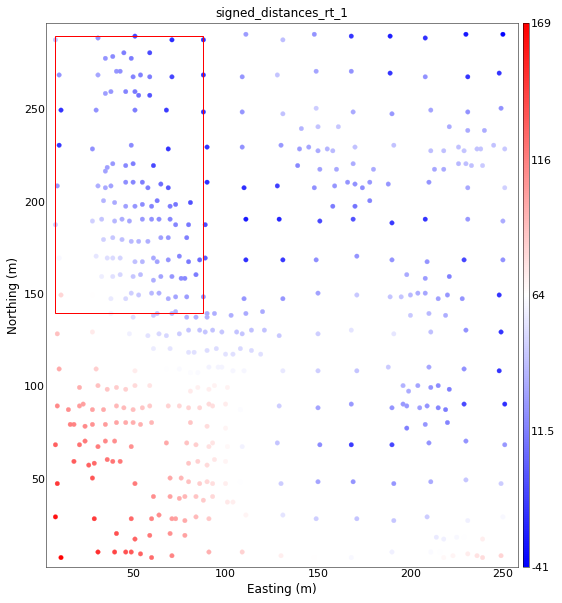

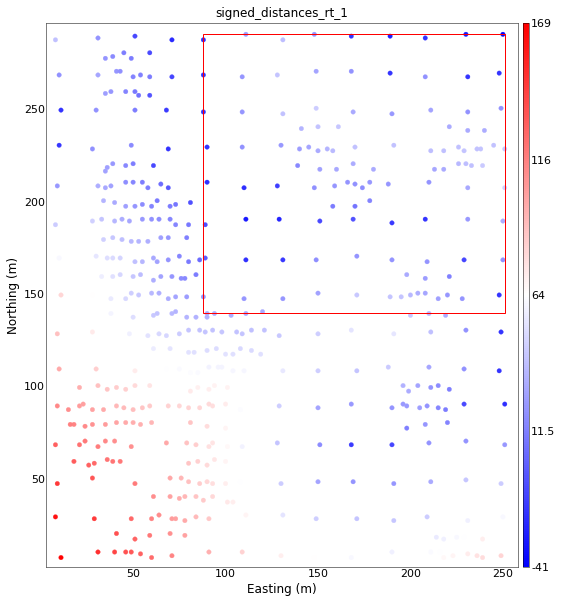

In [371]:
for u, l in zip(allups, alllows):

    fig, axs = plt.subplots(1,1, figsize=(10,10))
    _ = gs.location_plot(data, var='signed_distances_rt_1', cmap='bwr',ax=axs)

    rect1 = Rectangle((l[0], l[1]), u[0]-l[0], u[1]-l[1], linewidth=1, edgecolor='red', facecolor='none')
    axs.add_patch(rect1)

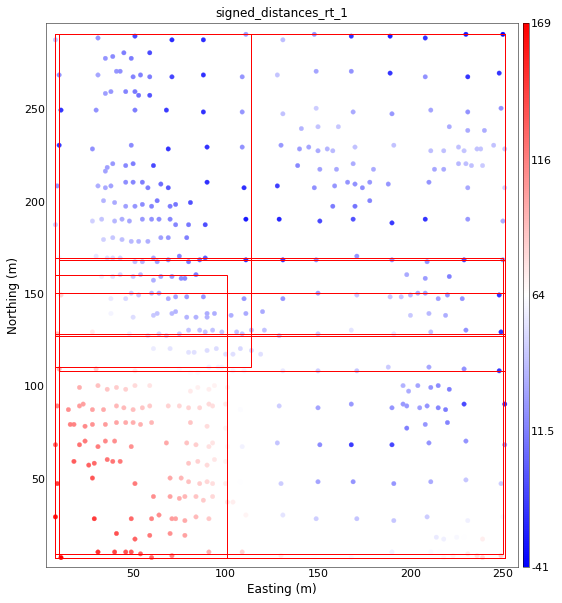

In [295]:
fig, axs = plt.subplots(1,1, figsize=(10,10))
_ = gs.location_plot(data, var='signed_distances_rt_1', cmap='bwr',ax=axs)
for u, l in zip(ups, lows):

    rect1 = Rectangle((l[0], l[1]), u[0]-l[0], u[1]-l[1], linewidth=1, edgecolor='red', facecolor='none')
    axs.add_patch(rect1)

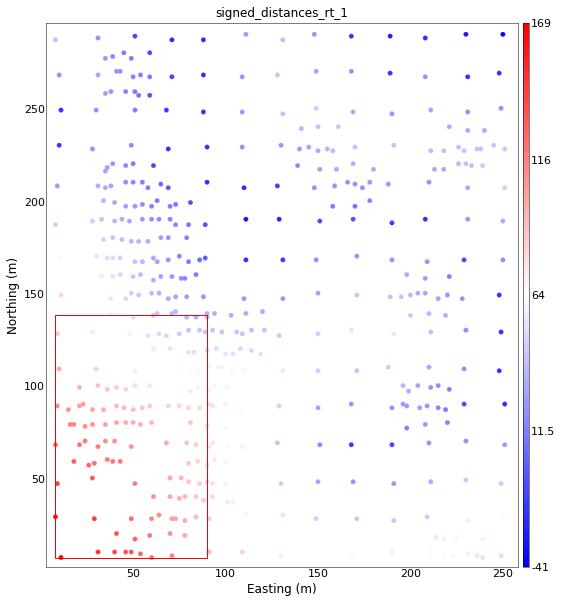

In [375]:
c=0
fig, axs = plt.subplots(1,1, figsize=(10,10))
_ = gs.location_plot(data, var='signed_distances_rt_1', cmap='bwr',ax=axs)
rect1 = Rectangle((lows[c][0], lows[c][1]), ups[c][0]-lows[c][0], ups[c][1]-lows[c][1], linewidth=1, edgecolor='red', facecolor='none')
axs.add_patch(rect1)

In [354]:
grids_used = np.array(ptest.grid_idx_list)[used_idxs]

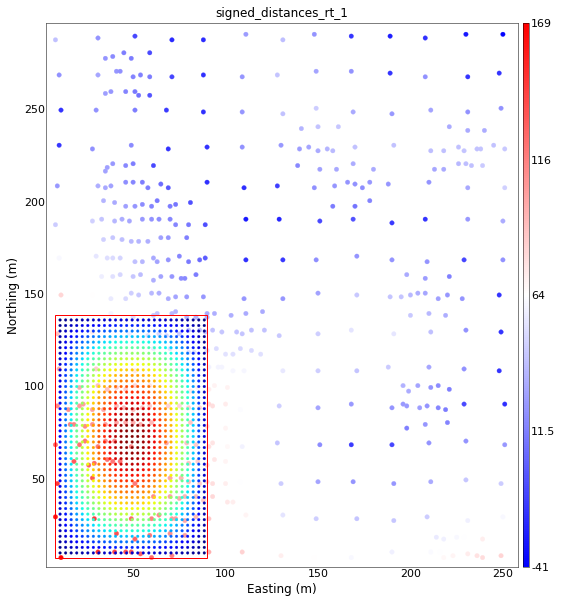

In [356]:
c=0
coords = np.array(ptest.grid_coords).T[grids_used[c]].T
x, y, z = coords[0], coords[1], coords[2]
fig, axs = plt.subplots(1,1, figsize=(10,10))
_ = gs.location_plot(data, var='signed_distances_rt_1', cmap='bwr',ax=axs)
rect1 = Rectangle((lows[c][0], lows[c][1]), ups[c][0]-lows[c][0], ups[c][1]-lows[c][1], linewidth=1, edgecolor='red', facecolor='none')
axs.add_patch(rect1)
axs.scatter(x, y, s=7, c=ptest.weights[c], cmap='jet')

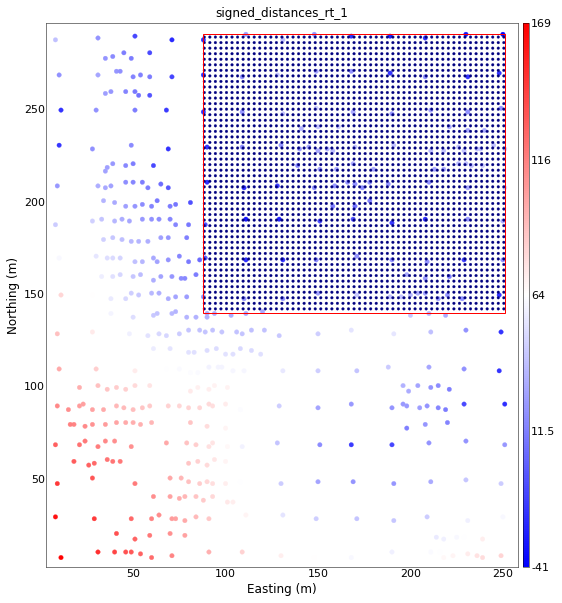

In [379]:
c=3
coords = np.array(ptest.grid_coords).T[grids_used[c]].T
x, y, z = coords[0], coords[1], coords[2]
fig, axs = plt.subplots(1,1, figsize=(10,10))
_ = gs.location_plot(data, var='signed_distances_rt_1', cmap='bwr',ax=axs)
rect1 = Rectangle((lows[c][0], lows[c][1]), ups[c][0]-lows[c][0], ups[c][1]-lows[c][1], linewidth=1, edgecolor='red', facecolor='none')
axs.add_patch(rect1)
axs.scatter(x, y, s=7, c=ptest.norm_weights[c], cmap='jet')

In [380]:
ptest.norm_weights

[array([1., 1., 1., ..., 1., 1., 1.]),
 array([1., 1., 1., ..., 1., 1., 1.]),
 array([1., 1., 1., ..., 1., 1., 1.]),
 array([1., 1., 1., ..., 1., 1., 1.])]

In [222]:
yobs = data['signed_distances_rt_1'].values

xflat = np.vstack((
    grid_coords[0],
    grid_coords[1],
    #grid_coords[2]
)).T

In [210]:
yflat = RBFInterpolator(xobs, yobs)(xflat)

In [11]:
interp = LinearNDInterpolator(xobs, yobs)
Z = interp(xflat)

In [12]:
def plot_contour(x,y,z,resolution = 50,contour_method='linear'):
    resolution = str(resolution)+'j'
    X,Y = np.mgrid[min(x):max(x):complex(resolution),   min(y):max(y):complex(resolution)]
    points = [[a,b] for a,b in zip(x,y)]
    Z = griddata(points, z, (X, Y), method=contour_method)
    return X,Y,Z

In [13]:
Xrbf, Yrbf, Zrbf = plot_contour(grid_coords[0],grid_coords[1],yflat,resolution = 50,contour_method='linear')
Xlin, Ylin, Zlin = plot_contour(grid_coords[0],grid_coords[1],Z,resolution = 50,contour_method='linear')

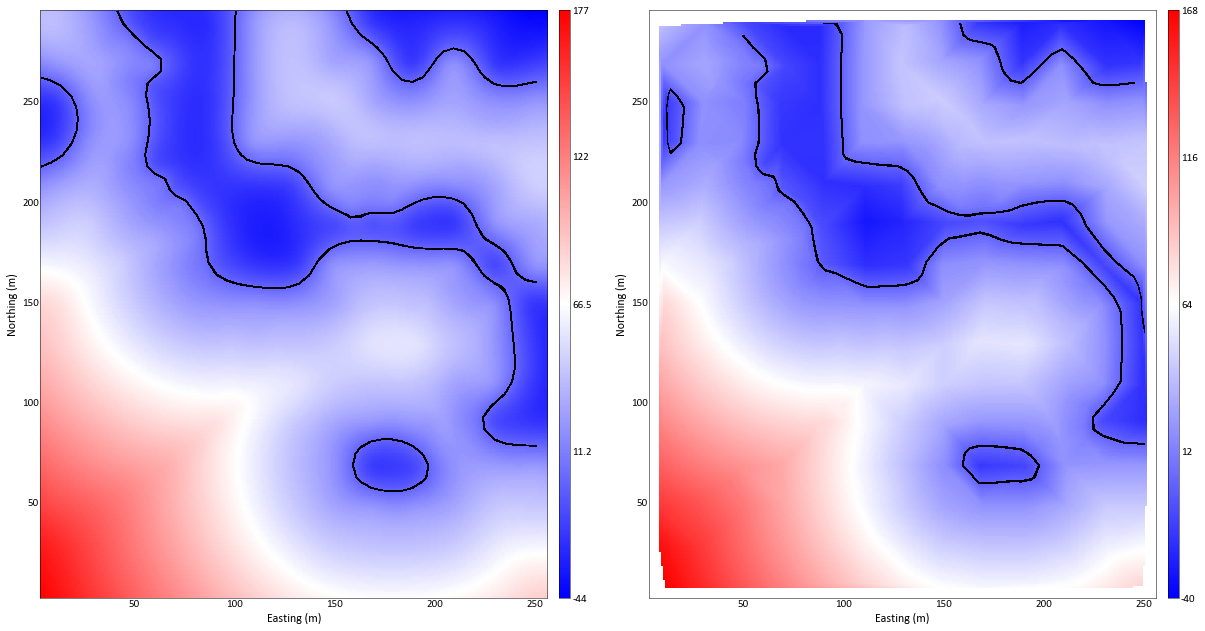

In [14]:
fig, axs = plt.subplots(1,2, figsize=(20,20))
_ = gs.slice_plot(yflat, griddef=grid, cmap='bwr', ax=axs[0])
axs[0].contourf(Xrbf,Yrbf,Zrbf, [0, 1], colors=['black'])
_= gs.slice_plot(Z, griddef=grid, cmap='bwr', ax=axs[1])
axs[1].contourf(Xlin,Ylin,Zlin, [0, 1], colors=['black'])
plt.savefig('both.png', facecolor='white', bbox_inches='tight')
plt.show()